# Enterprise Risk Analysis: Exploring the Aircraft Leasing Industry

# Project Goal
## Our project aim is to determine how to avoid potential risks associated with operating an aircraft leasing business.

## Data Source and Data Exploration

Our data is from the [National Transportation Safety Board (NTSB)](https://www.ntsb.gov/Pages/AviationQuery.aspx) dataset of aviation accidents. Each row in the dataset represents an aircraft accident. The types of flights included are non-military and non-state flights, collectively called "civil aviation,"which includes both private and commercial.

## Import Packages and Read in Data

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.api.types as ptypes

#Hides warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [318]:
df = pd.read_csv("project_data/Aviation_Data.csv", delimiter=",")

C:\Users\42ben\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Initial Data Exploration

In [319]:
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N5069P,Piper,PA24-180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.9222,-81.8781,NaN,NaN,Fatal(3),Destroyed,NaN,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,NaN,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

## Convert Event.Date to Date Type

In [321]:
# Coerce 'Event.Date' into pandas date time object
df["Event.Date"] = pd.to_datetime(df['Event.Date'], format='%Y-%m-%d', errors = 'coerce')
# Assert that Event.Date is not a datetime64 dtype:
assert ptypes.is_datetime64_any_dtype(df['Event.Date'])



## Clean Event.Id Column
### This removes nulls from Event.Id, Investigation.Type, Accident.Number, and Event.Date

In [322]:
# Drop rows where 'Event.Id' is NULL
df_clean = df.dropna(subset=['Event.Id'])


In [323]:
# Drop duplicates using the Event.Id column
df_clean1 = df_clean.drop_duplicates(subset=['Event.Id'])


In [324]:
# After dropping rows where NOT Event.Id null,
# We now have a dataset where first 4 columns have no nulls
# We think this makes sense because without an id or accident number, the event wasn't properly documented
df_clean1.isna().sum()

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     222
Latitude                  53739
Longitude                 53748
Airport.Code              38350
Airport.Name              35834
Injury.Severity             990
Aircraft.damage            3103
Aircraft.Category         55770
Registration.Number        1285
Make                         63
Model                        92
Amateur.Built               100
Number.of.Engines          6027
Engine.Type                7024
FAR.Description           56036
Schedule                  75591
Purpose.of.flight          6122
Air.carrier               71418
Total.Fatal.Injuries      11267
Total.Serious.Injuries    12322
Total.Minor.Injuries      11760
Total.Uninjured            5863
Weather.Condition          4473
Broad.phase.of.flight     27114
Report.Status              6361
Publication.Date          15057
dtype: i

# Subset based on Event.Date
- We wanted to only look at past 30 years because planes older than that likely no longer flying

In [325]:
# Subset data to look at past 30 years of data:
df_30 = df_clean1[df_clean1['Event.Date'] >= '1993-01-01']

In [326]:
# Check Date Range
print(df_30['Event.Date'].min())
print(df_30['Event.Date'].max())


1993-01-01 00:00:00
2022-12-29 00:00:00


# Create Total Injuries Column

In [327]:
# Create Total Injuries Column
df_30['Total.Injuries'] = df_30['Total.Fatal.Injuries'] + df_30['Total.Minor.Injuries'] + df_30['Total.Serious.Injuries'] 
# Sanity Check new 'Total.Injuries' Column:
df_30[['Total.Injuries', 'Total.Fatal.Injuries', 'Total.Minor.Injuries', 'Total.Serious.Injuries']].head()

,Total.Injuries,Total.Fatal.Injuries,Total.Minor.Injuries,Total.Serious.Injuries
32026,2.0,1.0,1.0,0.0
32027,1.0,0.0,0.0,1.0
32028,1.0,0.0,1.0,0.0
32029,1.0,0.0,1.0,0.0
32030,0.0,0.0,0.0,0.0


# Clean Make and Model Columns

In [328]:
#Cleaning the Make column (this gets rid of a lot of unique values)
#Start by making everything lowercase
df_30['Make'] = df_30['Make'].str.lower()
#capitalize the beginning of each word
df_30['Make'] = df_30['Make'].str.title()
#Get rid of whitespace
df_30['Make'] = df_30['Make'].str.strip()

In [329]:
#Cleaning the Model column (I don’t think this got rid of any unique values)
#Start by making everything uppercase
df_30['Model'] = df_30['Model'].str.upper()
#Get rid of whitespace
df_30['Model'] = df_30['Model'].str.strip()

In [330]:
df_30['Model']

32026            8A
32027          269C
32028           152
32029    PA-32R-301
32030           120
            ...    
90343     PA-28-151
90344          7ECA
90345         8GCBC
90346          210N
90347     PA-24-260
Name: Model, Length: 56405, dtype: object

# Clean Aircraft.Category Column:
- Here we will throw out only those Aircraft.Category rows where Airplane or NULL
- Concatenate Make and Model = Make_Model
- Keep the rows that are (Aircraft.Category = NULL) ONLY IF...
- The Make_Model value is one that exists in rows that are (Aircraft.Category = 'Airplane')

In [331]:
#Get rid of non airplane rows but keep the nulls
#First fill nulls with ‘n/a’
df_30['Aircraft.Category'].fillna('n/a', inplace=True)
#Keep only rows with ‘Airplane’ or ‘n/a’
df_clean2 = df_30.loc[(df_30['Aircraft.Category'] == 'Airplane') | (df_30['Aircraft.Category'] == 'n/a')]


In [332]:
df_clean2['Aircraft.Category'].value_counts()

n/a         27840
Airplane    24294
Name: Aircraft.Category, dtype: int64

In [333]:
# Create concatenated Make.Model column:
df_clean2["Make.Model"] = df_clean2['Make'].astype(str) +"_"+ df_clean2["Model"]

In [334]:
df_clean2["Make.Model"].head()

32026         Luscombe_8A
32027         Hughes_269C
32028          Cessna_152
32029    Piper_PA-32R-301
32030          Cessna_120
Name: Make.Model, dtype: object

In [335]:
# Preview counts for each Make.Model, grouped on Aircraft.Category:
df_clean2.groupby(['Aircraft.Category','Make.Model']).size()


Aircraft.Category  Make.Model                 
Airplane           177Mf Llc_PITTS MODEL 12       1
                   2007 Savage Air Llc_EPIC LT    1
                   2021Fx3 Llc_CCX-2000           2
                   3Xtrim_450 ULTRA               1
                   5 Rivers Llc_SQ-2              1
                                                 ..
n/a                nan_RV-4                       1
                   nan_SUPER QUICKIE 2            1
                   nan_TERATORN                   1
                   nan_UNKNOWN                    1
                   nan_VANS RV-6                  1
Length: 14186, dtype: int64

### Split into two dataframes:

In [336]:
# Isolate a dataframe only containing rows where category is Airplane:
df_plane = df_clean2[df_clean2['Aircraft.Category'] == 'Airplane']
# And one for category = n/a:
df_na = df_clean2[df_clean2['Aircraft.Category'] == 'n/a']

### Explore results:

In [337]:
# Category = Airplane

# 27,520 rows
# 7,484 unique Make.Model values
print(df_plane.shape)
print(df_plane['Make.Model'].unique().shape)
df_plane['Make.Model'].tail()

(24294, 33)
(7037,)


90328                          Piper_PA42
90332             Cirrus Design Corp_SR22
90335                  Swearingen_SA226TC
90336                        Cessna_R172K
90345    American Champion Aircraft_8GCBC
Name: Make.Model, dtype: object

In [338]:
# Category = n/a

# 55,770 rows
# 11,038 unique Make.Model values
print(df_na.shape)
print(df_na['Make.Model'].unique().shape)
df_na['Make.Model'].tail()

(27840, 33)
(7151,)


90342    Air Tractor_AT502
90343      Piper_PA-28-151
90344        Bellanca_7ECA
90346          Cessna_210N
90347      Piper_PA-24-260
Name: Make.Model, dtype: object

### Filter the **category = n/a** rows to only contain the Make.Model values of Airplanes

In [339]:
# Get a list of all of the unique values of "Make.Model" where aircraft.category = 'Aiplane':
airplane_make_model_list = list(df_plane['Make.Model'].unique())

In [340]:
# Go back to original dataframe "df_clean2" before we split it, and filter to only Make.Model values in airplane_make_model_list
df_ap_mm = df_clean2[df_clean2['Make.Model'].isin(airplane_make_model_list)]

In [341]:
# Sanity Check:
# Number of rows where 'Aircraft.Category' = 'Airplane' vs. Total Rows
print(df_ap_mm['Aircraft.Category'].value_counts())
print(df_ap_mm.shape)

Airplane    24294
n/a         19043
Name: Aircraft.Category, dtype: int64
(43337, 33)


### Now we only have Make.Model rows that we know are Airplanes, so we can replace all 'n/a' values with 'Airplane'

In [342]:
# Fill 'n/a' value with 'Airplane':
df_ap_mm['Aircraft.Category'] = df_ap_mm['Aircraft.Category'].replace(['n/a'], 'Airplane')


# Clean Make and Model Data
The Make and Model columns need to be cleaned to draw conclusions from the data.

In [343]:
#List of Aircraft Manufacturers used to clean data 
major_manufacturers=['Cessna',
'Piper',
'Beech',
'Boeing',
'Mooney',
'Bellanca',
'Air Tractor',
'Grumman',
'Maule',
'Aeronca',
'Champion',
'Mcdonnell Douglas',
'Airbus',
'Stinson',
'Luscombe',
'Cirrus',
'Aero Commander',
'Taylorcraft',
'North American',
'De Havilland',
'Embraer',
'Cirrus',
'Aviat',
'Ayres',
'Rockwell',
'Grumman',
'Socata',
'Dehavilland',
'Learjet',
'Aviat',
'Diamond Aircraft',
'Ercoupe',
'Bombardier',
]

#Filling null values
df_30['Make'].fillna('n/a', inplace=True)
#cleaning Make data and populating new column Make.Clean
#e.g. The Boeing Aircraft Company, Boeing inc and boeing all become Boeing in Make.Clean
for manufacturer in major_manufacturers:
    df_30.loc[df_30['Make'].str.contains(manufacturer, case=False), 'Make.Clean'] = manufacturer
#De Havilland is in the data as De Havilland and Dehavilland so it needs a special case
df_30.loc[df_30['Make'].str.contains('Dehavilland', case=False), 'Make.Clean'] = 'De Havilland'

# Cleaning Model Data
Below are groups of the most popular aircraft models for Boeing, Airbus and Cessna. These were created using data from the companies websites. For example, Airbus considers its A319, A320 and A321 airliners to be variants in the A320 family so they are grouped together as the A320.

In [344]:
#Aircraft model groups
boeing_aircraft_models = {'707':['707'],'717':['717'],'727':['727'],'737':['737'],'747':['747'],'757':['757'],
                          '767':['767'],'777':['777'],'787':['787'],'Model 75':
                          ['A75','A 75','A-75','B75','B 75','B-75','D75','D 75','D-75','E75','E 75','E-75','PT 17','PT-17','PT17']}
airbus_aircraft_models = {'A220':['220','BD50'],'A300':['300','F462'],'A310':['310'],'A320':['319','320','321'],
                          'A330':['330'],'A340':['340'],'A350':['350'],'A380':['380']}
cessna_aircraft_models = ['152','172','150','180','182','140','170','188','185','177','210']
#Filling null values in Model data
df_30['Model'].fillna('n/a', inplace=True)

# Boeing 

In [345]:
#First creating a new data frame with just Boeing data
boeing_data = pd.DataFrame(df_30.loc[df_30['Make.Clean']=='Boeing'])
#Taking model data with variant information, grouping it by family and saving it in new column called Model.Clean
#e.g. 737-200, B737-800 and 737-3B7 are all stored as 737

#Looping through the boeing_aircraft_models dictionary
for model in boeing_aircraft_models:
    #Looping through individual dictionary entrys which are lists of variants that make up each aircraft model
    for variant in boeing_aircraft_models[model]:
        boeing_data.loc[boeing_data['Model'].str.contains(variant, case=False), 'Model.Clean'] = model
        
boeing_data['Model.Clean'].value_counts()

737         917
Model 75    247
747         233
767         185
757         174
777         158
727          93
787          41
717          23
707          15
Name: Model.Clean, dtype: int64

# Airbus

In [346]:
#First creating a new data frame with just Airbus data
airbus_data = pd.DataFrame(df_30.loc[df_30['Make.Clean']=='Airbus'])

In [347]:
#removeing dashes and white space then saving the first four characters 
airbus_data['Model'] = airbus_data['Model'].str.replace('-','')
airbus_data['Model'] = airbus_data['Model'].str.replace(' ','')
airbus_data['Model'] = airbus_data['Model'].str[:4]


In [348]:
#Looping through the airbus_aircraft_models dictionary
for model in airbus_aircraft_models:
    #Looping through individual dictionary entrys which are lists of variants that make up each aircraft model
    for variant in airbus_aircraft_models[model]:
        airbus_data.loc[airbus_data['Model'].str.contains(variant, case=False), 'Model.Clean'] = model
#Merging the Airbus_data back into the main data frame
df_30['Model'].fillna('n/a', inplace=True)

# Cessna

In [349]:
#Taking model data with variant information, grouping it by family and saving it in new column called Model.Clean
for model in cessna_aircraft_models:
    df_30.loc[df_30['Model'].str.contains(model, case=False), 'Model.Clean'] = model
df_30['Model.Clean'].fillna('n/a', inplace=True)

# Combining Data Frames

In [350]:
combined_data = airbus_data.merge(boeing_data, how = 'outer')

# Exploring Boeing Accidents

In [351]:
combined_data['Purpose.of.flight'].value_counts()

Unknown                      401
Personal                     211
Positioning                   17
Instructional                 14
Other Work Use                12
Business                      11
Ferry                          6
Flight Test                    6
Air Race show                  5
Public Aircraft                4
Aerial Application             3
Air Race/show                  3
Public Aircraft - Federal      3
Skydiving                      1
Aerial Observation             1
Public Aircraft - Local        1
Air Drop                       1
Public Aircraft - State        1
External Load                  1
Name: Purpose.of.flight, dtype: int64

In [352]:
combined_data['Purpose.of.flight'].isna().sum()

1904

In [353]:
#There is already an 'Uknown' category so adding the nulls to this
combined_data['Purpose.of.flight'].fillna('Unknown', inplace=True)

In [354]:
#Sanity check
combined_data['Purpose.of.flight'].value_counts()

Unknown                      2305
Personal                      211
Positioning                    17
Instructional                  14
Other Work Use                 12
Business                       11
Ferry                           6
Flight Test                     6
Air Race show                   5
Public Aircraft                 4
Aerial Application              3
Air Race/show                   3
Public Aircraft - Federal       3
Skydiving                       1
Aerial Observation              1
Public Aircraft - Local         1
Air Drop                        1
Public Aircraft - State         1
External Load                   1
Name: Purpose.of.flight, dtype: int64

In [355]:
#Getting rid of the 'Uknown' values because these don't add value to us
combined_data = combined_data[combined_data['Purpose.of.flight'] != 'Unknown']

In [356]:
#Sanity check
combined_data['Purpose.of.flight'].value_counts()

Personal                     211
Positioning                   17
Instructional                 14
Other Work Use                12
Business                      11
Flight Test                    6
Ferry                          6
Air Race show                  5
Public Aircraft                4
Aerial Application             3
Public Aircraft - Federal      3
Air Race/show                  3
Public Aircraft - State        1
Aerial Observation             1
Public Aircraft - Local        1
External Load                  1
Air Drop                       1
Skydiving                      1
Name: Purpose.of.flight, dtype: int64

In [357]:
#Create new DataFrame for only Boeing planes
Boeing_Purpose = combined_data[combined_data['Make'] == 'Boeing']

In [358]:
#Create a list of the top 5 purposes of flights
Purpose_Frequencies = Boeing_Purpose['Purpose.of.flight'].value_counts()
Top_Purposes = list(Purpose_Frequencies.index[0:5])
Top_Purposes

['Personal', 'Positioning', 'Instructional', 'Business', 'Other Work Use']

In [359]:
#Create a list of the counts of the top 5 purposes of flights
Top_Purpose_Counts = list(Purpose_Frequencies.values[0:5])
Top_Purpose_Counts

[168, 13, 11, 8, 6]

<ipython-input-316-1c4f977c198b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45)


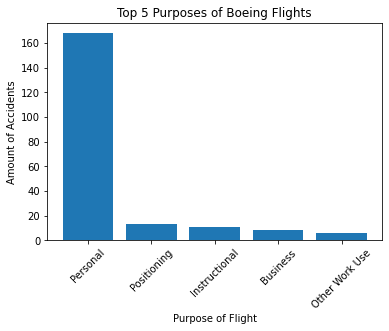

In [316]:
#Create bar chart that shows purposes of flights for only Boeing planes
fig, ax = plt.subplots()

x = Top_Purposes
y = Top_Purpose_Counts

ax.bar(x, y)
ax.set_title('Top 5 Purposes of Boeing Flights')
ax.set_ylabel('Amount of Accidents')
ax.set_xlabel('Purpose of Flight')
ax.set_xticklabels(x, rotation=45);